
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Юрий Кашницкий, программист-исследователь Mail.Ru Group, и Мария Сумарокова, старший эксперт по аналитике VimpelCom. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center>Домашнее задание № 3 (демо). <br>Деревья решений в игрушечной задаче и на данных Adult репозитория UCI

**В задании Вам предлагается разобраться с тем, как работает дерево решений, на игрушечном примере, затем обучить и настроить деревья и (при желании) случайный лес в задаче классификации на данных Adult репозитория UCI. Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/1bC3jNPH7XZUty_DaIvt0fPrsiS8YFkcpeBKHPSG0hw0/edit).**

Подключаем необходимые библиотеки

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

## Часть 1. Игрушечный набор данных "девушка в баре"

**Цель –  "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.**

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**
<img src='../../img/toy_data.png'>

### Создание набора данных

In [2]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

**Обучающая выборка**

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


**Тестовая выборка**

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Потраченные_деньги_много,Алкоголь_в_напитке_да,Уровень_красноречия_средний,Алкоголь_в_напитке_нет,Потраченные_деньги_мало,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий
0,1,1,0,0,0,1,0,1
1,0,1,0,0,1,1,0,0
2,1,0,1,1,0,1,0,0
3,0,0,1,1,1,0,1,0
4,1,1,0,0,0,0,1,0
5,1,1,0,0,0,0,1,1
6,1,1,1,0,0,1,0,0


In [7]:
df_test

,Потраченные_деньги_много,Алкоголь_в_напитке_да,Уровень_красноречия_средний,Алкоголь_в_напитке_нет,Потраченные_деньги_мало,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий
0,1,0,1,1,0,1,0,0
1,0,1,0,0,1,1,0,1
2,1,1,1,0,0,0,1,0


**Постройте от руки (или в графическом редакторе) дерево решений для этого набора данных. Дополнительно (для желающих) – можете сделать отрисовку дерева и написать код для построения всего дерева.**

<font color='red'>Вопрос 1.</font> Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

<font color='red'>Вопрос 2. </font> Рассмотрим разбиение обучающей выборки по признаку "Внешность\_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации  при данном разбиении (IG)? 

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

**Постройте с помощью `sklearn` дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.**

In [8]:
tree_1 = DecisionTreeClassifier()

In [9]:
y.info

<bound method Series.info of 0    0
1    1
2    0
3    1
4    1
5    0
6    0
Name: Поедет, dtype: int64>

In [10]:
tree_1.fit(df_train, y)

DecisionTreeClassifier()

In [11]:
tree_1.predict_proba(df_test)

array([[1., 0.],
       [0., 1.],
       [0., 1.]])

**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

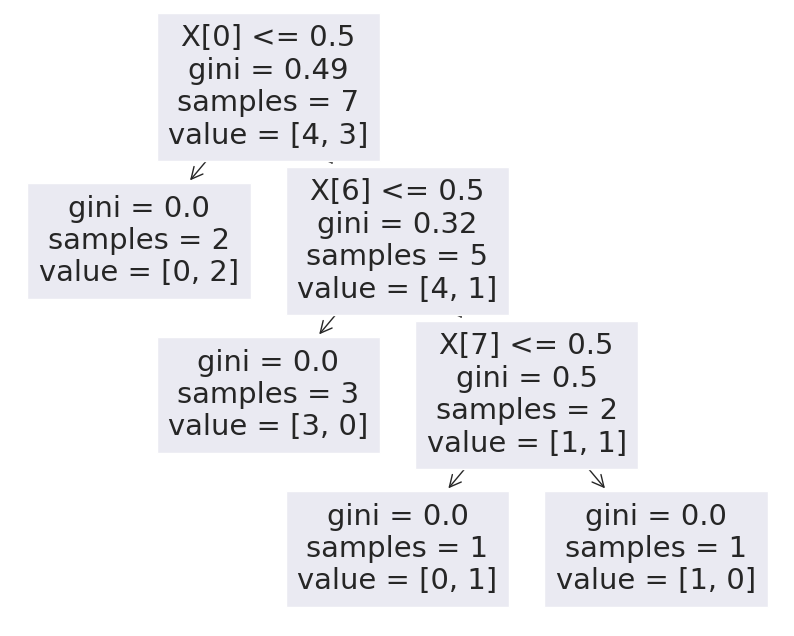

In [12]:
plot_tree_1 = plot_tree(tree_1)

## Часть 2. Функции для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [13]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![png](../../img/decision_tree3.png)

In [14]:
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Дальше пусть шарики разбиваются на 2 группы
![png](../../img/decision_tree4.png)

In [15]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

In [16]:
balls_left


[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [17]:
balls_right

[1, 0, 0, 0, 0, 0, 0]

**Реализуйте функцию для расчета энтропии Шеннона.**

In [18]:
def entropy(labels):
    
    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    counts = np.bincount(labels)
    probs = counts[np.nonzero(counts)] / n_labels
    n_classes = len(probs)

    if n_classes <= 1:
        return 0
    return - np.sum(probs * np.log(probs)) / np.log(n_classes)

Проверка

In [19]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878083
0.961236604722876
0.5916727785823274
0.9999999999999999


<font color='red'>Вопрос 3.</font> Чему равна энтропия состояния, заданного списком `balls_left`?

<font color='red'>Вопрос 4.</font> Чему равна энтропия игральной кости с несмещенным центром тяжести?

Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку  𝑄  (в нашем примере это признак " 𝑥≤12 ") определяется как

$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
где  𝑞  – число групп после разбиения,  𝑁𝑖  – число элементов выборки, у которых признак  𝑄  имеет  𝑖 -ое значение.

In [20]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    
    # Ваш код здесь
    pass

<font color='red'>Вопрос 5.  </font> Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [21]:
# Ваш код здесь

In [22]:
def best_feature_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    
    # Ваш код здесь
    pass

**Опционально:**

 - реализуйте алгоритм построения дерева за счет рекурсивного вызова функции `best_feature_to_split`
 - нарисуйте полученное дерево

## Часть 3. Набор данных "Adult"

**Описание набора:**

**[Набор](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) данных UCI Adult** (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [23]:
DATA_URL = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [24]:
data_train = pd.read_csv(DATA_URL + 'adult_train.csv', sep=';')

In [25]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [26]:
data_test = pd.read_csv(DATA_URL + 'adult_test.csv', sep=';') 

In [27]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [28]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [29]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

In [30]:
data_test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [31]:
# перекодируем target в числовое поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

In [32]:
data_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


столбец Target типа object, приведем к int64

In [34]:
data_train['Target'] = data_train['Target'].astype(int)
data_test['Target'] = data_test['Target'].astype(int)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


**Первичный анализ данных.**

In [35]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

In [37]:
# fig = plt.figure(figsize=(25, 15))
# cols = 5
# rows = np.ceil(float(data_train.shape[1]) / cols)
# for i, column in enumerate(data_train.columns):
#     ax = fig.add_subplot(rows, cols, i + 1)
#     ax.set_title(column)
#     if data_train.dtypes[column] == np.object:
#         data_train[column].value_counts().plot(kind="bar", axes=ax)
#     else:
#         data_train[column].hist(axes=ax)
#         plt.xticks(rotation="vertical")
# plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [38]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [39]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [40]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [41]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [42]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [43]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c].fillna(value=data_train[c].mode()[0], inplace=True) # value=data_train[c].mode() выдает серию, которую нельзя подставить
for c in categorical_columns_test:
    data_test[c].fillna(value=data_train[c].mode()[0], inplace=True) # data_train[c].fillna(value=data_train[c].mode()[0] берем 1-е значение серии
#     data_train[c].fillna(value=data_train[c].mode()[0] без этого код не работает
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

In [44]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


Колонки Workclass, Occupation, Country все еще имеют пропуски, попробуем иначе заменить их

In [45]:
# data_train["Workclass"].fillna(value=" Private", inplace=True)
# data_train["Occupation"].fillna(value=" Prof-specialty", inplace=True)
# data_train["Country"].fillna(value=" United-States", inplace=True)
# без пробелов " Private" будет считаться как новое значение
# после исправление value=data_train[c].mode() на value=data_train[c].mode()[0] код выше не нужен

In [46]:
data_train["Occupation"].value_counts()

 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [47]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [48]:
data_train['Education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64

In [49]:
data_train['Sex'].value_counts()

 Male      21790
 Female    10771
Name: Sex, dtype: int64

**Такие признаки как Sex (пол) можно закодировать 0 - мужской, 1 - женский. Признак Education наверное целесообразнее ранжировать от "Preschool" до "Doctorate"**

In [50]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Columns: 114 entries, Age to Country_ Yugoslavia
dtypes: int64(7), object(8), uint8(99)
memory usage: 6.8+ MB


In [51]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [52]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.917388,0.275303,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [53]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [54]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [55]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [56]:
set(data_train.columns) - set(data_test.columns)

set()

In [57]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [58]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [59]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 3.1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [87]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [88]:
tree_predictions = tree.predict(X_test)

/home/Nikolay/PycharmProjects/ODSml/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [89]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

<font color='red'>Вопрос 6.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

## 3.2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`. Проведите 5-кратную кросс-валидацию**

In [63]:
tree_params = {'max_depth': range(2,11), 'random_state': [17]}

locally_best_tree = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)                   

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 11), 'random_state': [17]},
             verbose=True)

In [64]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9, 'random_state': 17}
Best cross validaton score 0.8565770273854106


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [66]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17, )
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

/home/Nikolay/PycharmProjects/ODSml/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.847798046803022

<font color='red'>Вопрос 7.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

## 3.3. Случайный лес без настройки параметров  (опционально)¶

Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья.

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`), число деревьев сделайте равным ста, а `random_state` = 17.**

In [67]:
rf = RandomForestClassifier(random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [69]:
forest_predictions = rf.predict(X_test)

/home/Nikolay/PycharmProjects/ODSml/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [70]:
accuracy_score(forest_predictions, y_test)

0.8585467723112831

## 3.4. Случайный лес с настройкой параметров  (опционально)

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.**

In [83]:
%%time
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 10)}

locally_best_forest = GridSearchCV(rf, param_grid=forest_params, n_jobs=-1)

locally_best_forest.fit(X_train, y_train)

CPU times: user 25.4 s, sys: 473 ms, total: 25.9 s
Wall time: 25min 46s


GridSearchCV(estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 10)})

In [84]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 14, 'max_features': 75}
Best cross validaton score 0.8651456442624108


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [85]:
tuned_forest_predictions = locally_best_forest.predict (X_test)
accuracy_score(y_test, tuned_forest_predictions)

/home/Nikolay/PycharmProjects/ODSml/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.8625391560714943

**Зачем считать accuracy_score, если Best cross validaton score 0.8617058785471959 уже показал его, может другую метрику посмотреть?**

In [86]:
mean_squared_error(y_test, tuned_forest_predictions)

0.13746084392850563